# 2019 MLB Hitting dataset cleaning and analysis

### About the data
- All datasets were pulled from:  https://www.rotowire.com/baseball/stats.php
- [2019 and 2020 Hitting Data](https://www.rotowire.com/baseball/stats.php)


## Project Overview

In this notebook, we will examine a model to predict whether or not a team has good hitters - predicting the results of games based on W (Wins Earned). 

To accomplish this, we will examine 5 models.

#### Model building:

- Linear Regression
- RandomForest
- Lasso
- Ridge
- Elastic Net

Each model will be evaluated based on model score, MAE, and MSE.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

#Model Building Imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

#Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
# Read in dataset
df = pd.read_csv('data/hitting_data/2019-batting-players.csv', index_col='Player')

In [4]:
# looking at the first 5 rows of data
df.head(5)

,Team,Pos,Age,G,AB,R,H,2B,3B,HR,...,CS,BB,SO,SH,SF,HBP,AVG,OBP,SLG,OPS
Player,,,,,,,,,,,,,,,,,,,,,
Whit Merrifield,KC,2B,31,162,681,105,206,41,10,16,...,10,45,126,0,4,5,0.302,0.348,0.463,0.811
Marcus Semien,OAK,SS,29,162,657,123,187,43,7,33,...,8,87,102,0,1,2,0.285,0.369,0.522,0.891
Rafael Devers,BOS,3B,23,156,647,129,201,54,4,32,...,8,48,119,1,2,4,0.311,0.361,0.555,0.916
Jonathan Villar,BAL,2B,29,162,642,111,176,33,5,24,...,9,61,176,2,4,4,0.274,0.339,0.453,0.792
Ozzie Albies,ATL,2B,23,160,640,102,189,43,8,24,...,4,54,112,0,4,4,0.295,0.352,0.500,0.852


In [5]:
df = df.drop('Team', axis=1)

In [6]:
# Describing the dataset
print(round(df.describe()))

         Age      G     AB      R      H     2B     3B     HR    RBI     SB  \
count  694.0  694.0  694.0  694.0  694.0  694.0  694.0  694.0  694.0  694.0   
mean    29.0   72.0  234.0   33.0   60.0   12.0    1.0   10.0   32.0    3.0   
std      4.0   51.0  191.0   31.0   54.0   11.0    2.0   11.0   31.0    6.0   
min     21.0    1.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
25%     26.0   25.0   56.0    6.0   12.0    2.0    0.0    1.0    5.0    0.0   
50%     28.0   69.0  191.0   26.0   44.0    9.0    0.0    6.0   23.0    1.0   
75%     31.0  120.0  392.0   54.0  100.0   20.0    2.0   15.0   53.0    4.0   
max     46.0  162.0  681.0  135.0  206.0   54.0   10.0   53.0  126.0   46.0   

          CS     BB     SO     SH     SF    HBP    AVG    OBP    SLG    OPS  
count  694.0  694.0  694.0  694.0  694.0  694.0  694.0  694.0  694.0  694.0  
mean     1.0   23.0   58.0    0.0    2.0    3.0    0.0    0.0    0.0    1.0  
std      2.0   23.0   47.0    1.0    2.0    4.0    0.0

In [7]:
# Getting count of missing values
missing_value_count = df.isnull().sum()

# Getting missing values for all columns
missing_value_count[:len(df.columns)]

Pos    0
Age    0
G      0
AB     0
R      0
H      0
2B     0
3B     0
HR     0
RBI    0
SB     0
CS     0
BB     0
SO     0
SH     0
SF     0
HBP    0
AVG    0
OBP    0
SLG    0
OPS    0
dtype: int64

### There are no missing values in this dataset

Below we have defined several functions that will help to visualize the relationships between data points.

In [8]:
# Visualization Functions
def create_distplot(df, column):
  plt.figure(figsize=(10,5))
  plt.title(f"Displot: {column}")
  sns.distplot(df[column], hist=True, color="g", kde_kws={"shade": True})

def create_scatter(df, x, y):
  plt.figure(figsize=(10,5))
  plt.title(f"Scatter: {x} vs {y}")
  sns.scatterplot(df[x], df[y])

def create_heatmap(df):
  corr = df.corr()
  plt.figure(figsize=(16,8))
  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(220, 10, as_cmap=True)

  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})
  
def create_lineplot(df, x, y, hue=None, style=None):
  plt.figure(figsize=(16,8))
  plt.title(f"Lineplot: {x} vs {y}")
  sns.lineplot(x=x, y=y,
               hue = hue,
               style=style,
               data=df)

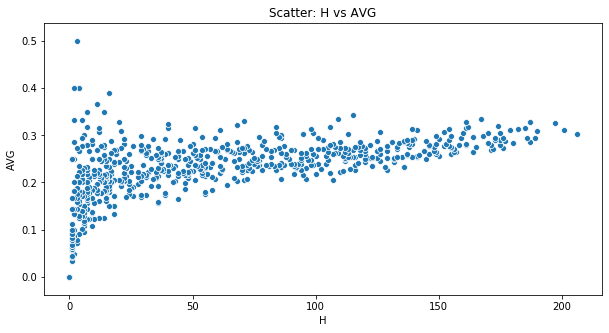

In [9]:
# Scatter for Hits vs Batting Average
create_scatter(df, 'H', 'AVG')

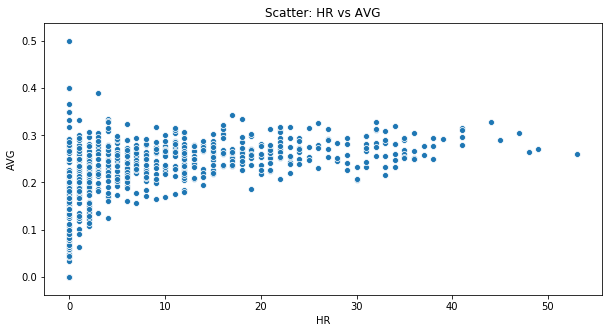

In [10]:
# Scatter for Homeruns vs Batting Average
create_scatter(df, 'HR', 'AVG')

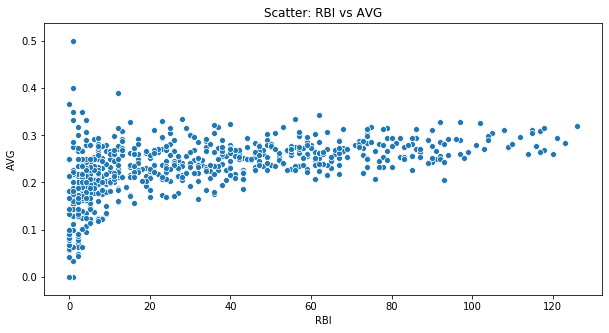

In [11]:
#Scatter for Runs Batted In vs Batting Average
create_scatter(df, 'RBI', 'AVG')

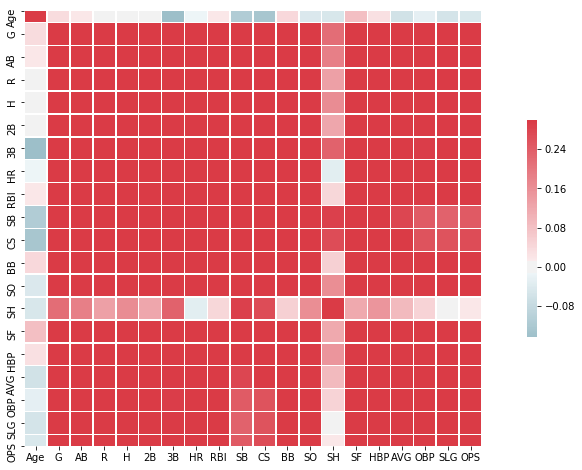

In [12]:
#Heatmap for data
create_heatmap(df)

In [13]:
# Getting all cont features in one list
cont_features = df[['Age',
 'G',
 'AB',
 'R',
 'H',
 '2B',
 '3B',
 'HR',
 'RBI',
 'SB',
 'CS',
 'BB',
 'SO',
 'SH',
 'SF',
 'HBP',
 'AVG',
 'OBP',
 'SLG',
 'OPS']]

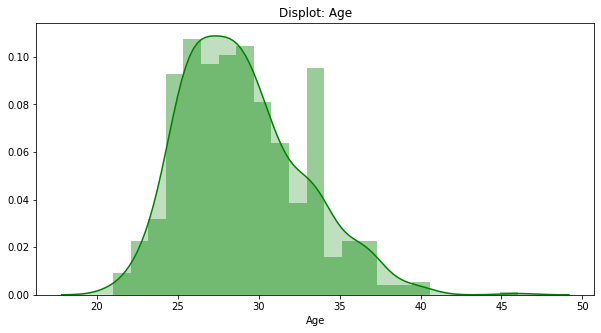

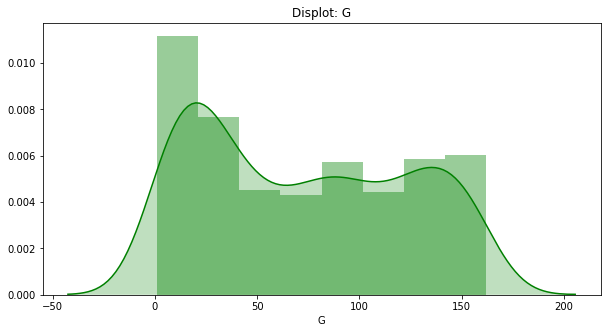

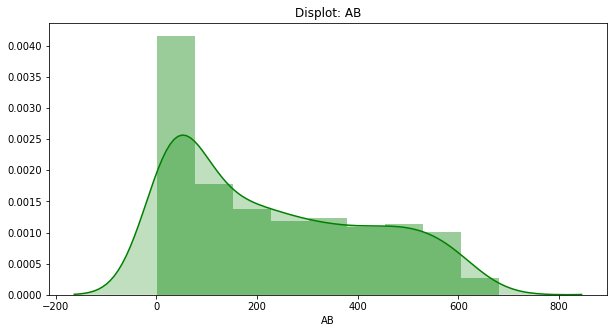

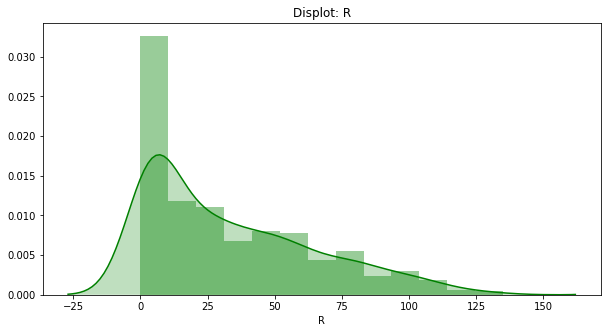

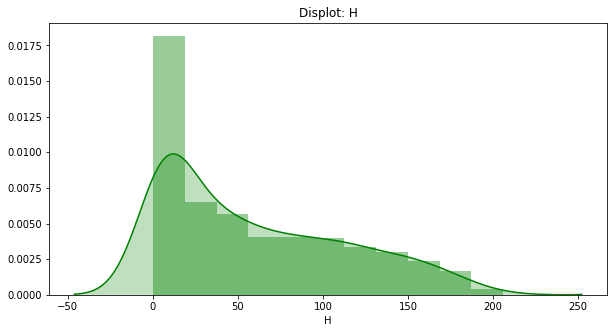

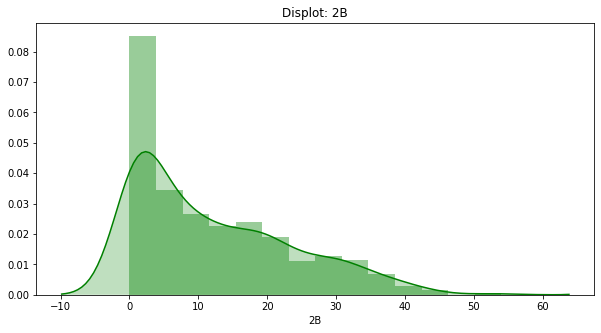

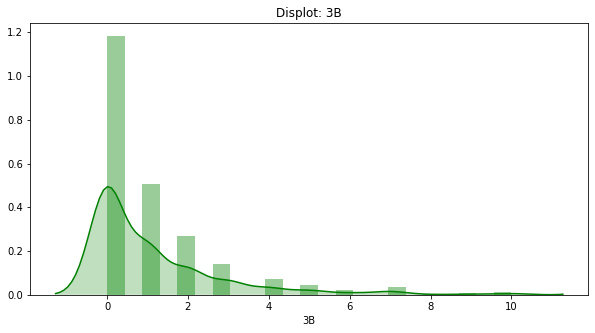

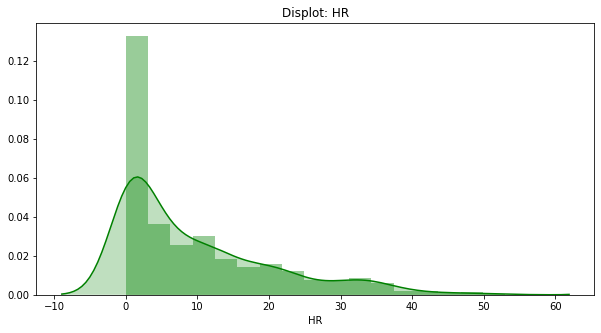

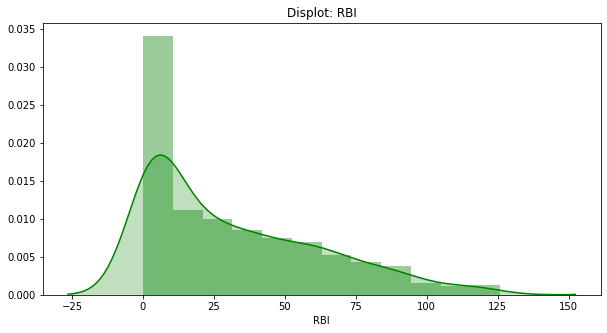

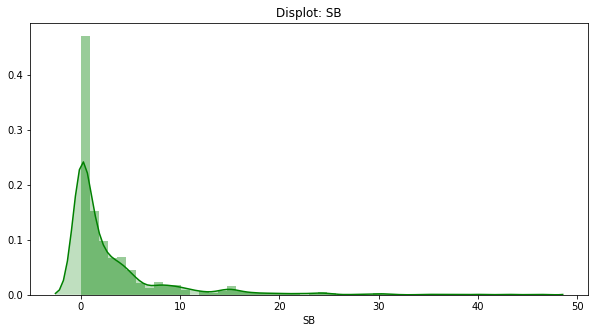

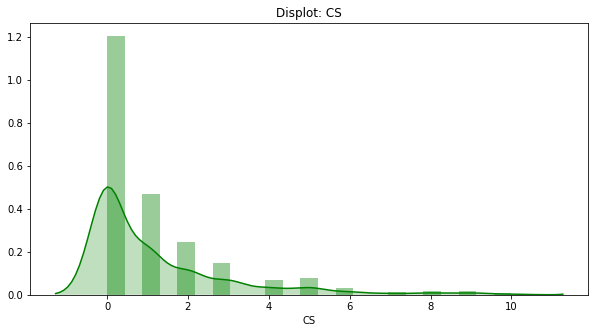

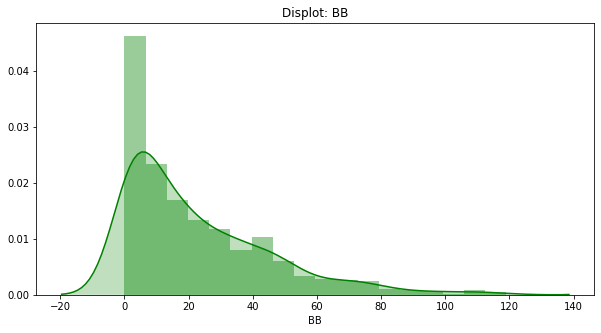

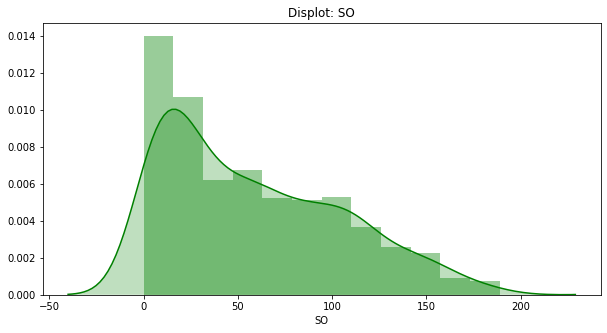

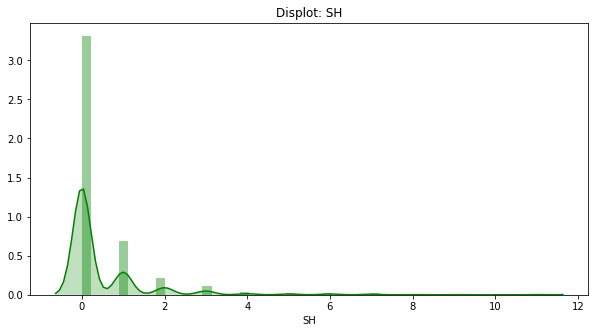

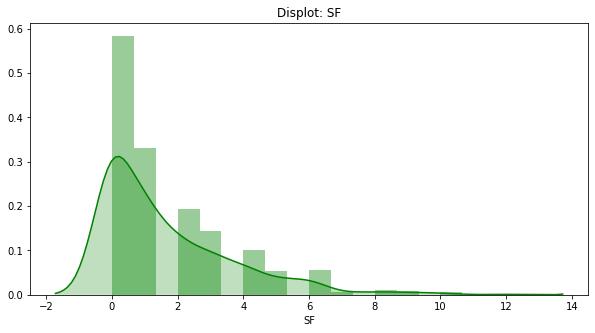

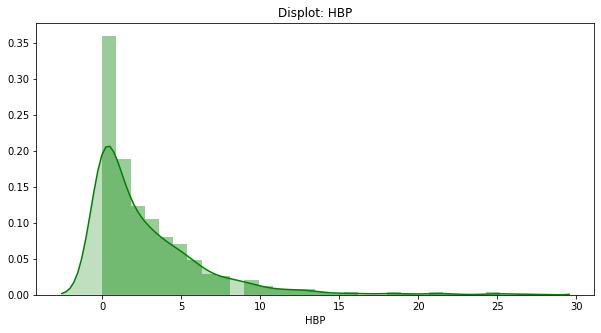

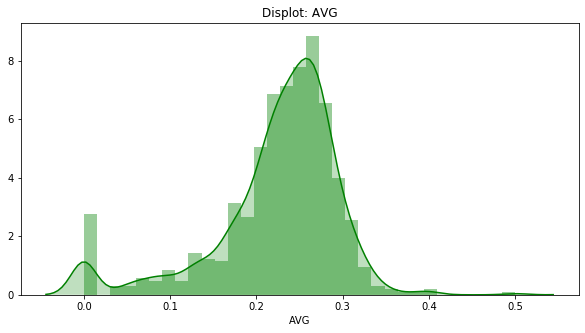

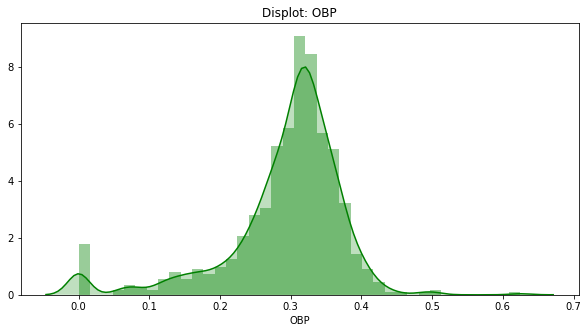

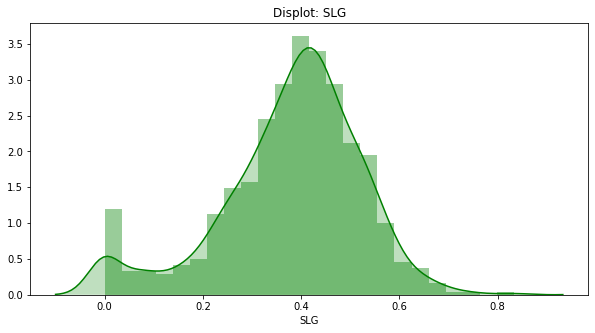

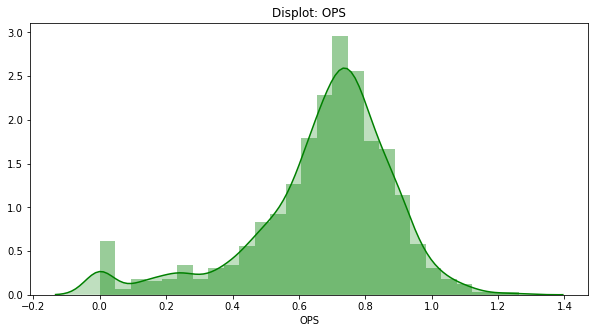

In [14]:
# making dist plots for all cont features
for feature in cont_features:
  create_distplot(df, feature)

## Correlation Matrix

In [15]:
df_corr = df.corr()
c = df_corr

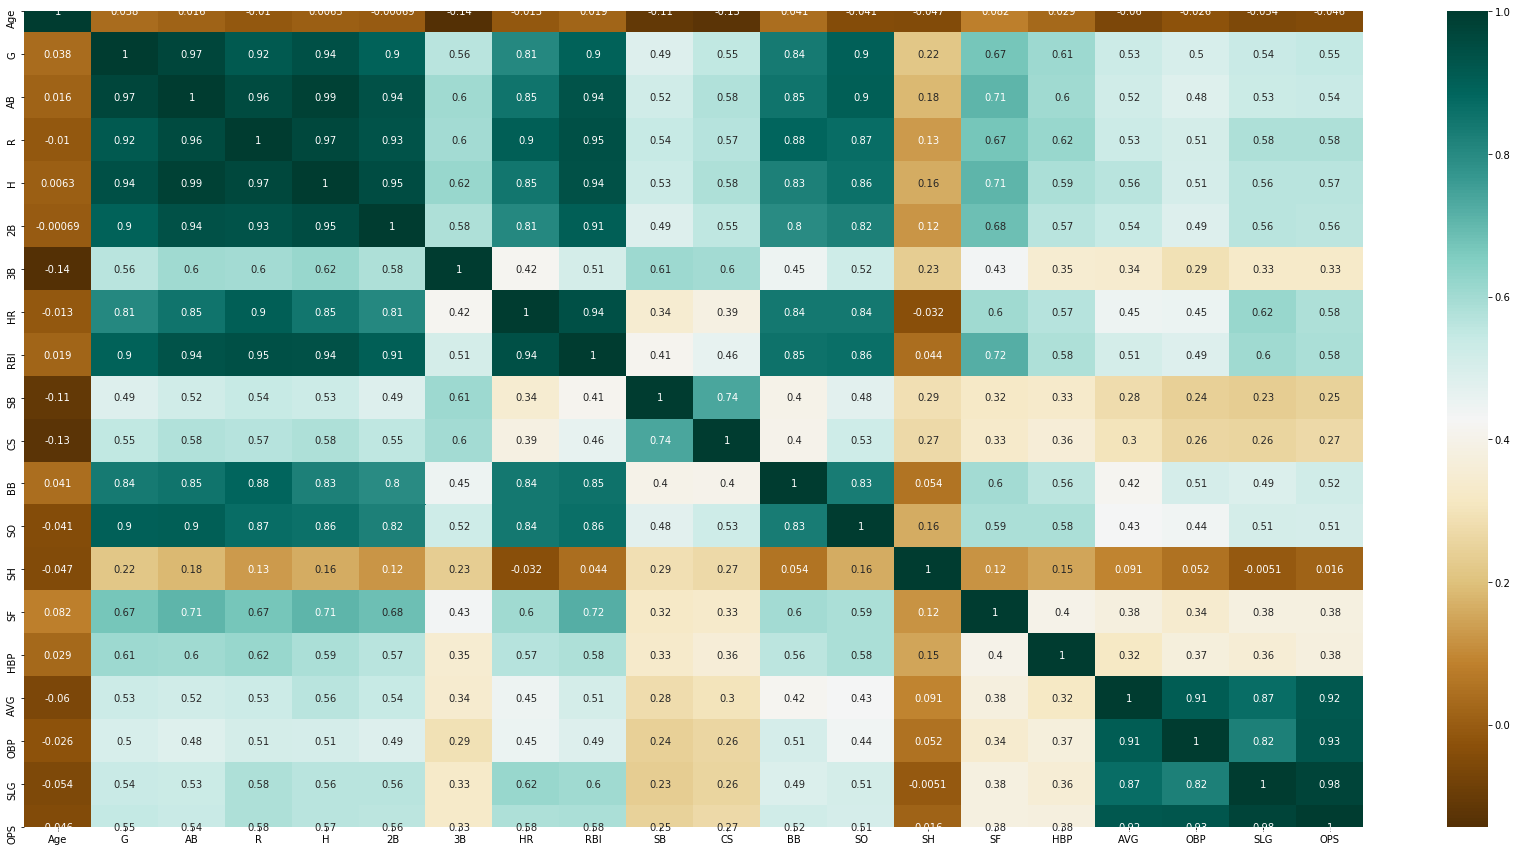

In [16]:
#visualizing the correlation matrix
plt.figure(figsize=(30,15))
sns.heatmap(c,cmap="BrBG", annot=True)

For model building, we are looking to gather the features that have a correlation of greater than 0.5.

In [19]:
selected_features = []

for i in range(len(df_corr['AVG'])):
  if df_corr['AVG'].values[i] >= 0.5 and df_corr['AVG'].values[i] != 1.0:
    selected_features.append(df_corr['AVG'].index[i])
    
selected_features

['G', 'AB', 'R', 'H', '2B', 'RBI', 'OBP', 'SLG', 'OPS']

In [20]:
# Splitting Data into train and test
X = df[selected_features]
y = df['AVG']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### The function below computes the Model scores for each model.

The Mean absolute error (MAE) is a linear score which means that all the individual differences are weighted equally in the average. 

Mean squared error (MSE) is a quadratic scoring rule which measures the average magnitude of the error.

In [21]:
#Function to test different Models
def test_model(model_to_test, X_test, X_train, y_test, y_train):
    f_steps = [
                ('model', model_to_test)
      ]

    f_pipe = Pipeline(steps=f_steps)
    f_pipe.fit(X_train, y_train)

    f_preds = f_pipe.predict(X_test)
    print("-" * 10 + " Model Stats " + "-" * 10)
    print('\n')
    print(f"Model Score: {f_pipe.score(X_test, y_test)}")
    print(f"MAE: {mean_absolute_error(y_test, f_preds)}")
    print(f"MSE: {mean_squared_error(y_test, f_preds)}")
    print('\n')
    print('-' * 80)
    print('\n')
    plt.figure(figsize=(10,5))
    plt.title("Model Predictions")
    plt.scatter(y_test.index[:20], y_test.values[:20])
    plt.scatter(y_test.index[:20], f_preds[:20])
    plt.xticks(rotation=90)
    plt.legend(['Test Data', 'Predictions'])

    return f_pipe

---------- Model Stats ----------


Model Score: 0.9106913019158825
MAE: 0.016048235506176733
MSE: 0.0005112125891165689


--------------------------------------------------------------------------------




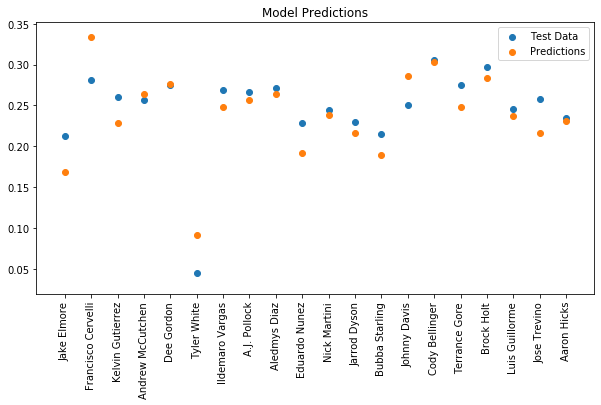

In [22]:
#LinearRegression
lr_model = test_model(LinearRegression(), X_test, X_train, y_test, y_train)

C:\Users\ajohn\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


---------- Model Stats ----------


Model Score: 0.8887758661456404
MAE: 0.01818421052631579
MSE: 0.000636658899521531


--------------------------------------------------------------------------------




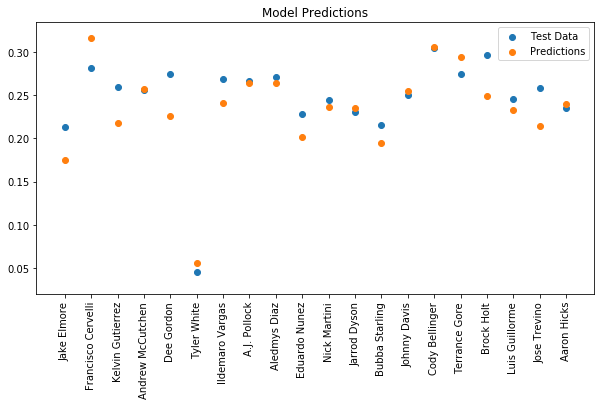

In [23]:
rf_model = test_model(RandomForestRegressor(), X_test, X_train, y_test, y_train)

---------- Model Stats ----------


Model Score: 0.278694830654028
MAE: 0.044014414093313387
MSE: 0.0041288283344721064


--------------------------------------------------------------------------------




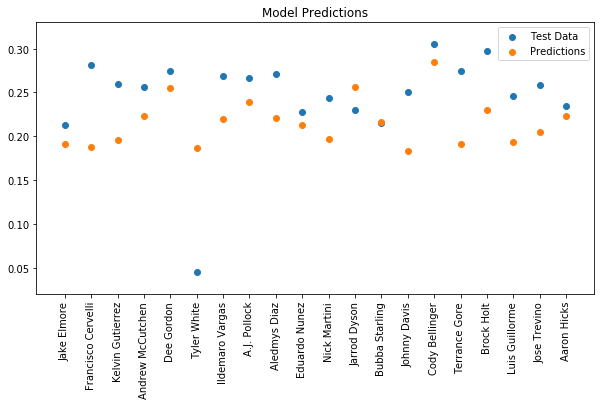

In [24]:
#Lasso Model
lasso_model = test_model(Lasso(alpha=0.3), X_test, X_train, y_test, y_train)

---------- Model Stats ----------


Model Score: 0.9059081803167687
MAE: 0.016251287244645793
MSE: 0.0005385916913674964


--------------------------------------------------------------------------------




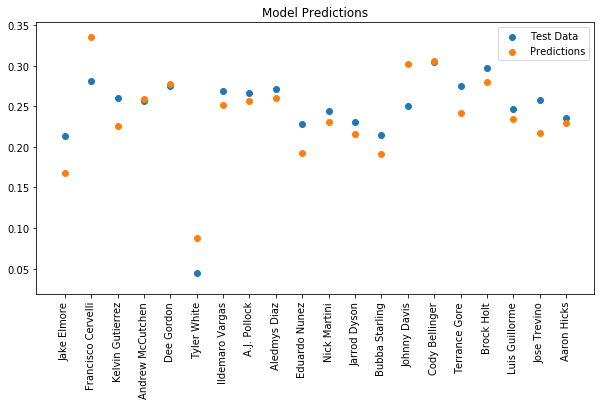

In [25]:
#Ridge Model
ridge_model = test_model(Ridge(alpha=0.7), X_test, X_train, y_test, y_train)

---------- Model Stats ----------


Model Score: 0.2957158008338976
MAE: 0.04287400578507556
MSE: 0.004031398471294262


--------------------------------------------------------------------------------




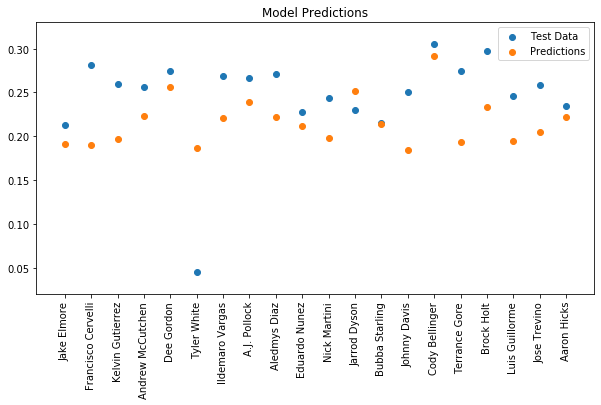

In [26]:
#ElasticNet Model
elastic_model = test_model(ElasticNet(alpha=0.5), X_test, X_train, y_test, y_train)

## Testing with the 2020 MLB Hitting data

In [29]:
# Bring in 2020 Data
df_2020 = pd.read_csv('data/hitting_data/2020-batting-players.csv', index_col='Player')

In [30]:
#Split out data into X and y
X_2020 = df_2020[selected_features]
y_2020 = df_2020['AVG']

In [31]:
# Make predictions
y_preds = lr_model.predict(X_2020)

In [32]:
# Score the Model
lr_model.score(X_2020, y_2020)

0.856967430496093

This function below is used to display the resulting scores for each of the models tested with 2020 data.

In [37]:
def score_new_dataset(model, X, y):
  # Make predictions
  f_preds = model.predict(X)

  # Score the Model
  f_score = model.score(X, y)

  #Print out findings
  print("Model Metrics")
  print("-" * 50)
  print('\n')
  print(f"Model Score: {f_score}")
  print(f"MAE: {mean_absolute_error(y, f_preds)}")
  print(f"MSE: {mean_squared_error(y, y_preds)}")

  # Graph Predictions
  print('\n')
  print('-' * 80)
  print('\n')
  plt.figure(figsize=(10,5))
  plt.title("First 10 Model Predictions")
  plt.scatter(y.index[:10], y.values[:10])
  plt.scatter(y.index[:10], f_preds[:10])
  plt.xticks(rotation=45)
  plt.legend(['Test Data', 'Predictions'])

  #Return predictions
  return f_preds

Model Metrics
--------------------------------------------------


Model Score: 0.856967430496093
MAE: 0.031243454186079544
MSE: 0.002016120096139699


--------------------------------------------------------------------------------




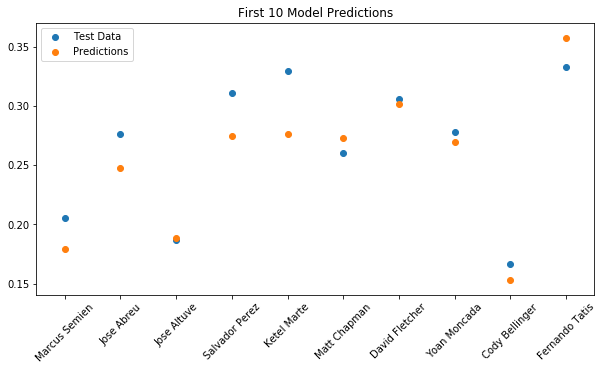

In [34]:
#LinearRegression Scoring on 2020 Data
lr_preds = score_new_dataset(lr_model, X_2020, y_2020)

Model Metrics
--------------------------------------------------


Model Score: 0.673623789776424
MAE: 0.03444357894736842
MSE: 0.002016120096139699


--------------------------------------------------------------------------------




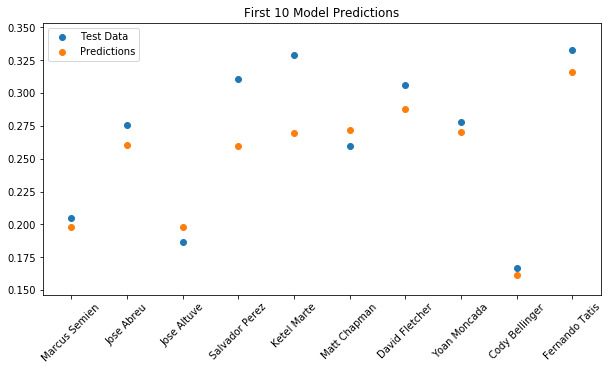

In [35]:
#RandomForest Scoring on 2020 Data
rf_preds = score_new_dataset(rf_model, X_2020, y_2020)

Model Metrics
--------------------------------------------------


Model Score: 0.8427213318913156
MAE: 0.03220798059848665
MSE: 0.002016120096139699


--------------------------------------------------------------------------------




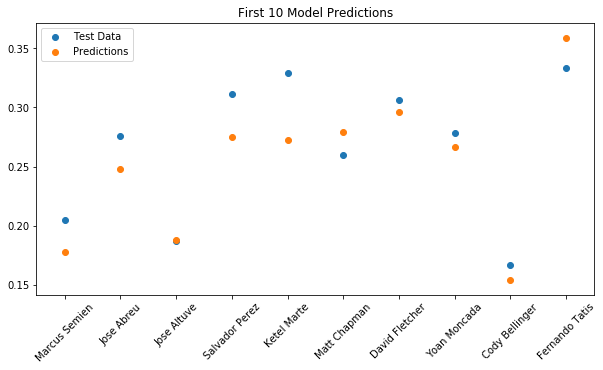

In [36]:
#RidgeRegression Scoring on 2020 Data
ridge_preds = score_new_dataset(ridge_model, X_2020, y_2020)

Model Metrics
--------------------------------------------------


Model Score: -0.05641645499864456
MAE: 0.08499927046507144
MSE: 0.002016120096139699


--------------------------------------------------------------------------------




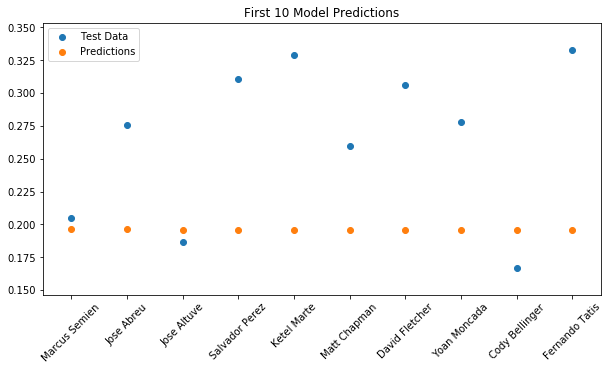

In [38]:
#LassoRegression Scoring on 2020 Data
lasso_preds = score_new_dataset(lasso_model, X_2020, y_2020)

Model Metrics
--------------------------------------------------


Model Score: -0.04512271564997561
MAE: 0.0843429122238012
MSE: 0.002016120096139699


--------------------------------------------------------------------------------




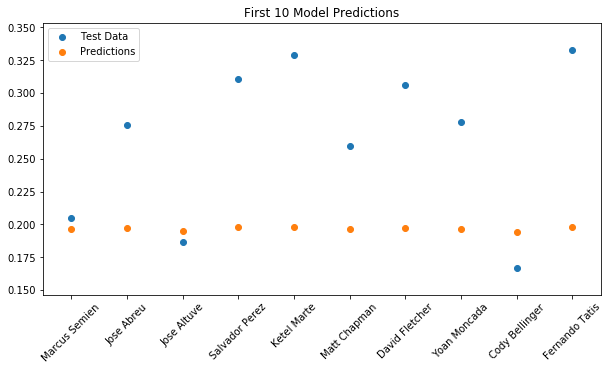

In [39]:
#ElasticNetRegression Scoring on 2020 Data
elastic_preds = score_new_dataset(elastic_model, X_2020, y_2020)

# Comparing Models for Top 20 Predictions

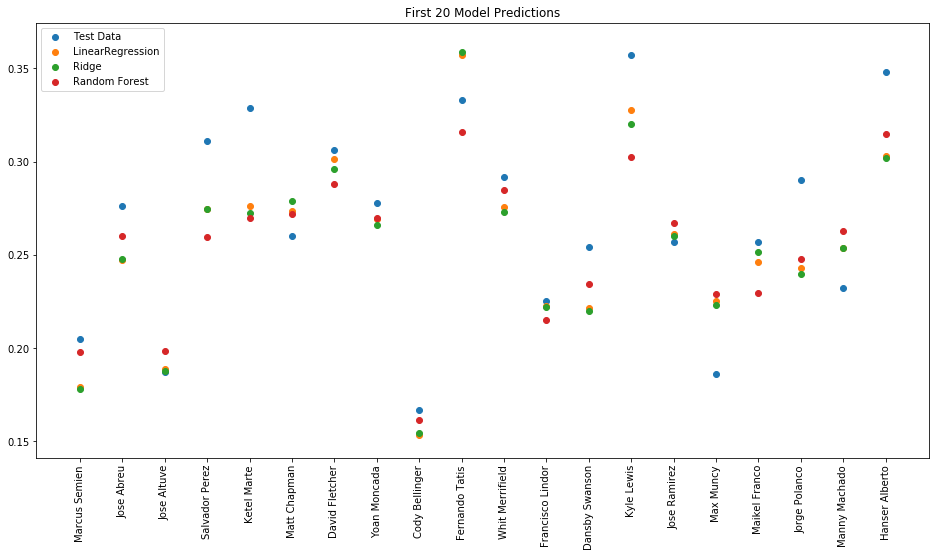

In [46]:
plt.figure(figsize=(16,8))
plt.title("First 20 Model Predictions")
plt.scatter(y_2020.index[:20], y_2020.values[:20])
plt.scatter(y_2020.index[:20], lr_preds[:20])
plt.scatter(y_2020.index[:20], ridge_preds[:20])
plt.scatter(y_2020.index[:20], rf_preds[:20])
plt.xticks(rotation=90)
plt.legend(['Test Data', 'LinearRegression', 'Ridge', 'Random Forest'], loc='upper left')

In [41]:
# LinearRegression Predictions
lr_predictions_df = pd.DataFrame({'Test Data': y_2020, 'LR Predictions':lr_preds})

In [42]:
# Lets see the lr_predictions_df 
lr_predictions_df.head()

,Test Data,LR Predictions
Player,,
Marcus Semien,0.205,0.179046
Jose Abreu,0.276,0.247479
Jose Altuve,0.187,0.188539
Salvador Perez,0.311,0.274616
Ketel Marte,0.329,0.276231


In [43]:
# RidgeRegression Predictions
ridge_predictions_df = pd.DataFrame({'Test Data': y_2020, 'Ridge Predictions':ridge_preds})

In [44]:
# Lets see the ridge_regression_df
ridge_predictions_df.head()

,Test Data,Ridge Predictions
Player,,
Marcus Semien,0.205,0.178127
Jose Abreu,0.276,0.247896
Jose Altuve,0.187,0.187913
Salvador Perez,0.311,0.274686
Ketel Marte,0.329,0.272591


In [45]:
# Exporting Model for later use
import pickle

filename_ridge = 'ridge_hitting_model.sav'
pickle.dump(ridge_model, open(filename_ridge, 'wb'))

filename_lr = 'lr_hitting_model.sav'
pickle.dump(lr_model, open(filename_lr, 'wb'))